In [1]:
### Montlhy values / large scale

In [2]:
from pyproj import Proj, Transformer, transform, CRS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import xesmf as xe
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as colors
import glob
import os
import pandas as pd
import time
from itertools import groupby
from scipy.stats import linregress
from scipy import ndimage
from contrack import contrack
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import shapely
import shapely.ops as sops
import shapely.vectorized as sv

In [85]:
### some functions
def preprocess(ds):
    """
    Different variable names in time
    """
    if "valid_time" in ds:
        ds = ds.rename({"valid_time": "time"})
    if "valid_time_bnds" in ds:
        ds = ds.rename({"valid_time_bnds": "time_bnds"})
    if "pressure_level" in ds:    
        ds = ds.rename({"pressure_level": "level"})    
    return xr.decode_cf(ds)  # makes time usable if units are valid
def calculate_smoothed_field(
    data,
    passes,
    weights=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]]),
    mode="wrap",
    *args,
    **kwargs
):
    """
    Calculate smoothed field based on a two-dimensional weight kernel
    and multiple smoothing passes. Default weight kernel is a 3x3
    5-point smoothing with double-weighted centre. The arguments
    "weight" and "mode" must be accepted by scipy.ndimage.convolve.
    Values at the latitude border are always set to NaN.
    Dimension names ("time_name", "lon_name", "lat_name"), size ("ntime", "nlon", "nlat")
    and resolution ("dlon", "dlat") can be passed as key=value arguments.

    Parameters
    ----------
        data : xarray.DataArray
            data to smooth
        passes : int or float
            number of smoothing passes of the 5-point smoothing
        weigths : array_like, optional
            array of weight, two-dimensional
            (see scipy.ndimage.convolve function)
        mode : string, optional
            defines how the array is extended at boundaries
            (see scipy.ndimage.convolve function)

    Returns
    -------
        smoothed data: xarray.DataArray
            Data containing the smoothed field
    """

    # perform smoothing
    smoothed = []
    for step in data[kwargs["time_name"]]:
        temp = data.sel({kwargs["time_name"]: step})
        for p in range(passes):
            temp = ndimage.convolve(temp, weights=weights, mode=mode) / np.sum(weights)

        # set latitude border values to nan
        border_size = int(weights.shape[0] / 2 + 0.5)
        temp[np.arange(-border_size, border_size), :] = np.nan

        smoothed.append(temp)

    # define DataArray
    da = xr.DataArray(
        smoothed,
        coords=[
            data[kwargs["time_name"]],
            data[kwargs["lat_name"]],
            data[kwargs["lon_name"]],
        ],
    )

    # set name
    da.name = "smooth_" + data.name

    # assign attributes
    da = da.assign_attrs(data.attrs)
    da.attrs["smooth_passes"] = passes

    return da

### Project figures
dir_figures='/users/edolores/TOOLS/HW_contrack/figures/'

# Tracking blocking ICON 2.5 km

In [38]:
# ICON (already regridded to 0.5° from filename)
inpath = '/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Z500/'
fvar   = 'z500'
dvar   = 'geopot'
temp = xr.open_mfdataset(
    f"{inpath}/{fvar}_day_*_0p5deg.nc",
    chunks={"time": 365, "lon": -1, "lat": -1}
)[dvar].squeeze()

##NH
temp=temp.sel(lat=slice(0,90))

In [15]:
# -----------------------
# Ensure same season selection (Apr–Oct) "we will use icon climatology"
# -----------------------
months_sel = [4,5,6,7,8,9,10]
temp  = temp.sel(time=temp["time.month"].isin(months_sel))
#etemp = etemp.sel(time=etemp["time.month"].isin(months_sel))

# (Optional) also slice ICON period if you like
# temp = temp.sel(time=slice("2017-01-01", "2023-12-31"))

# -----------------------
# Prepare time helpers
# -----------------------
t_icon   = temp.time
doy_icon = t_icon.dt.dayofyear

#t_era    = etemp.time
#doy_era  = t_era.dt.dayofyear

# Preallocate output with same shape as ICON
icon_std = xr.zeros_like(temp)

print('Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)')

# helper for circular day-of-year difference (handles wrap around)
def circ_doy_diff(a, b):
    # a, b are numpy arrays or scalars of day-of-year (1..366)
    d = np.abs(a - b)
    return np.minimum(d, 365 - d)

# -----------------------
# Main loop over ICON times; stats taken from ERA5
# -----------------------
for tt in range(t_icon.size):
    # 30-day window (±15 days) in DOY space on ERA5
    w_doy = circ_doy_diff(doy_icon.values, doy_icon.values[tt]) <= 15

    # 8-year window centered on ICON time[tt] (±1475 days) on ERA5
    w_time = np.abs((t_icon.values - t_icon.values[tt]).astype('timedelta64[D]')) <= np.timedelta64(1475, 'D')

    # Combined mask over ERA5 time
    vec = w_doy & w_time

    # Compute ERA5 climatology and std over that window
    # These broadcast over lat/lon (same 0.5° grid as ICON)
    # (If any std==0, avoid division by zero)
    clim = temp.isel(time=vec).mean('time')
    std  = temp.isel(time=vec).std('time')
    
#    icon_std[tt, :, :] = xr.where(std > 0, (temp.isel(time=tt) - clim) / std, np.nan)
    icon_std[tt, :, :] = (temp.isel(time=tt) - clim)

Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)


In [16]:
print('select months')
icon_std = icon_std.sel(time=icon_std.time.dt.month.isin([5,6,7,8,9])).compute()
icon_std

select months


<xarray.DataArray 'geopot' (time: 612, lat: 181, lon: 720)> Size: 319MB
array([[[  34.570312,   37.73047 ,   42.765625, ...,   40.11328 ,
           36.648438,   31.585938],
        [  36.25    ,   40.964844,   37.484375, ...,   36.58203 ,
           35.539062,   35.953125],
        [  36.871094,   33.015625,   34.55078 , ...,   38.664062,
           37.671875,   36.9375  ],
        ...,
        [1514.5312  , 1514.4258  , 1514.1602  , ..., 1514.8984  ,
         1514.7891  , 1514.5     ],
        [1493.3086  , 1493.2812  , 1493.3008  , ..., 1493.4805  ,
         1493.3789  , 1493.332   ],
        [1468.9297  , 1468.9297  , 1468.9297  , ..., 1468.9297  ,
         1468.9297  , 1468.9297  ]],

       [[ 102.609375,  106.03516 ,  106.60156 , ...,   99.70703 ,
          101.75    ,  101.23047 ],
        [ 101.37891 ,  104.91016 ,  106.41406 , ...,  100.640625,
          101.94531 ,   98.67969 ],
        [  99.96094 ,  101.05078 ,  103.984375, ...,   93.41016 ,
           99.24609 ,  104.48828 ],
...
        [ 676.6953  ,  675.6836  ,  673.5547  , ...,  681.53125 ,
          680.4258  ,  677.6719  ],
        [ 614.5781  ,  614.3281  ,  613.6328  , ...,  615.95703 ,
          615.28906 ,  614.95703 ],
        [ 568.1133  ,  568.1133  ,  568.1133  , ...,  568.1133  ,
          568.1133  ,  568.1133  ]],

       [[ 141.35938 ,  139.01562 ,  139.85547 , ...,  144.39453 ,
          144.19922 ,  143.42578 ],
        [ 149.71094 ,  148.83203 ,  148.19922 , ...,  147.79297 ,
          145.71094 ,  145.40234 ],
        [ 147.05469 ,  149.27344 ,  150.1914  , ...,  151.19531 ,
          147.95312 ,  145.79297 ],
        ...,
        [ 591.3906  ,  590.9297  ,  589.9336  , ...,  593.3789  ,
          592.91797 ,  591.7031  ],
        [ 548.41797 ,  548.3164  ,  548.08984 , ...,  549.0156  ,
          548.71094 ,  548.5508  ],
        [ 515.1719  ,  515.1719  ,  515.1719  , ...,  515.1719  ,
          515.1719  ,  515.1719  ]]], shape=(612, 181, 720), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2020-05-01T10:30:00 ... 2023-09-30T10:...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    plev     float64 8B 5e+04
Attributes:
    standard_name:  geopotential
    long_name:      geopotential at full level cell centre
    units:          m2 s-2
    param:          4.3.0
    cell_methods:   time: mean

In [17]:
### Save / open files
#print('write anomalies to netcdf')
icon_std.to_netcdf(inpath+'/ICON_'+fvar+'_NH_19592023_AMJJASO_daily_MA_simclim.nc')
#print('open anomalies in netcdf')
#icon_std = xr.open_dataset(inpath+'/ICON_'+fvar+'_NH_19592023_AMJJASO_daily_MA_simclim.nc')['t_2m']

In [23]:
### temporal smooth
smooth=2 ### 8 for 6-hourly, 2 for daily
icon_std_smooth = icon_std.rolling(time=smooth, center=True).mean()
icon_std_smooth

##### Smoothing spatially
#smooth_passes=5
#icon_std_smooth = calculate_smoothed_field(
#        icon_std, smooth_passes, time_name='time', lat_name='lat', lon_name='lon')

# Rename the DataArray
icon_std_smooth= icon_std_smooth.rename(dvar)

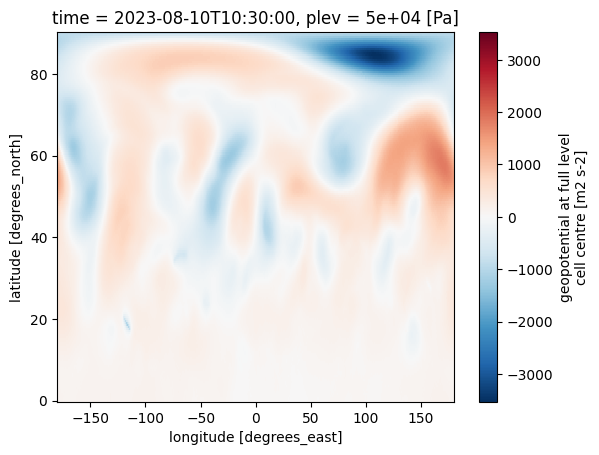

In [24]:
#snap=icon_std.sel(time='2023-08-10',drop=True)
snap=icon_std_smooth.sel(time='2023-08-10',drop=True)
snap.plot()

In [29]:
### Outputs
outpath='/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Blocking/'

### intitate
anom = contrack()
anom.read_xarray(icon_std_smooth.to_dataset())

def _get_resolution_patched(self, dim, force=False):
    # Try to get a pandas Index (DatetimeIndex, Float64Index, etc.)
    idx = self.ds[dim].to_index()

    # Case 1: time-like coordinate → return timedelta64[h]
    if isinstance(idx, (pd.DatetimeIndex, pd.TimedeltaIndex)):
        diffs = idx[1:] - idx[:-1]  # TimedeltaIndex
        delta = np.unique(diffs.to_numpy(dtype='timedelta64[h]'))
        return delta[0]

    # Case 2: numeric coordinate (e.g., degrees) → return float
    # (Work directly with numpy array to be robust to Index subclasses)
    arr = np.asarray(idx, dtype=float)
    diffs = np.diff(arr)
    # protect against tiny numerical noise
    delta = np.unique(np.round(diffs, 10))
    return float(delta[0])


# apply the patch
contrack._get_resolution = _get_resolution_patched

In [33]:
anom.set_up(force=True)
anom.ds=anom.ds.compute()

# Finally, track blocking anticyclones (>=150gmp, 50% overlap twosided, 5 timesteps persistence (here 5 days))
anom.run_contrack(variable=dvar,
                   threshold = anom[dvar].sel(lat=slice(50, 80)).quantile([0.90], dim='time').mean().values, # 177gmp
                   gorl='>=',
                   overlap=0.5, #0.5, 0.7
                   persistence=5, #5, 20
                   twosided=True)


### save blobs 
anom.to_netcdf(outpath+'BLOCKS_ICON_NH_20202024_AMJJASO_daily_MA_simclim.nc')

INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: 
Run ConTrack 
########### 
    threshold:    >= 1179.8924705074567 
    overlap:      0.5 
    persistence:  5 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Apply overlap...
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:704: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
54 contours tracked


In [34]:
### lifecycle
anom_df = anom.run_lifecycle(flag='flag', variable=dvar)
anom_df.to_csv(outpath+'BLOCKS_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv', index=False)

INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    geopot
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:848: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:860: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes

In [39]:
###Frequency
mean_hw = xr.where(anom['flag']>1,1,0).mean(dim='time')*100
#mean_hw.plot(cmap='YlOrRd', levels=np.arange(0, 5, 0.5))
anom

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:129: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims[self._get_name_time()]


Xarray dataset with 612 time steps. 
            Available fields: geopot, flag

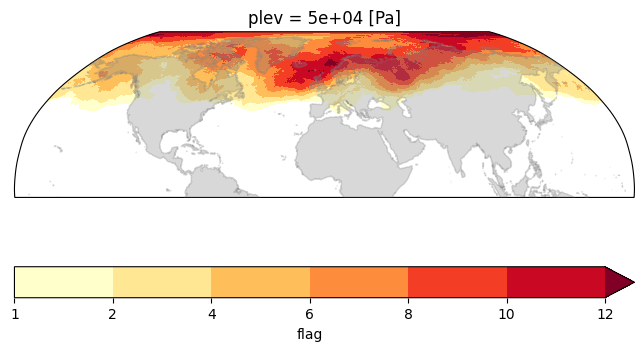

In [37]:
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw.plot(ax=ax1, cmap='YlOrRd', levels=[1,2,4,6,8,10,12],transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)

In [36]:
### Outputs
block_icon2km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Blocking/BLOCKS_ICON_NH_20202024_AMJJASO_daily_MA_simclim.nc')['flag']
#print(block_icon2km)
block_icon2km = xr.where(block_icon2km>1,1,0)

### heatwaves
heat_icon2km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
#print(jja_icon)

#jja_icon10km=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
#print(jja_icon10km)

In [55]:
def to_daily_mask(da, is_bool=True):
    """
    Convert time to daily (floor) and aggregate duplicates.
    For event masks, daily max is appropriate.
    """
    da2 = da.assign_coords(time=da.time.dt.floor("D"))
    da2 = da2.groupby("time").max()
    if is_bool:
        da2 = da2.astype(bool)
    return da2

def p_block_given_heatwave(block_flag, heat_flag, months, min_hw_days=5):
    """
    Compute P(block | heatwave) per grid cell:
      sum_t (H & B) / sum_t (H)
    """
    # daily masks
    H = to_daily_mask(heat_flag, is_bool=True)
    B = to_daily_mask(block_flag, is_bool=False)  # 0/1 integer ok

    # subset months
    H = H.sel(time=H.time.dt.month.isin(months))
    B = B.sel(time=B.time.dt.month.isin(months))

    # align on daily time + common grid
    H, B = xr.align(H, B, join="inner")

    # convert to int for counting
    H_i = H.astype("int8")
    B_i = (B > 0).astype("int8")

    num = (H_i * B_i).sum("time")  # co-occurrence count
    den = H_i.sum("time")          # heatwave-day count

    P = xr.where(den > 0, num / den, np.nan)
    if min_hw_days is not None:
        P = P.where(den >= min_hw_days)

    P.name = "P_block_given_heatwave"
    return P, den, num

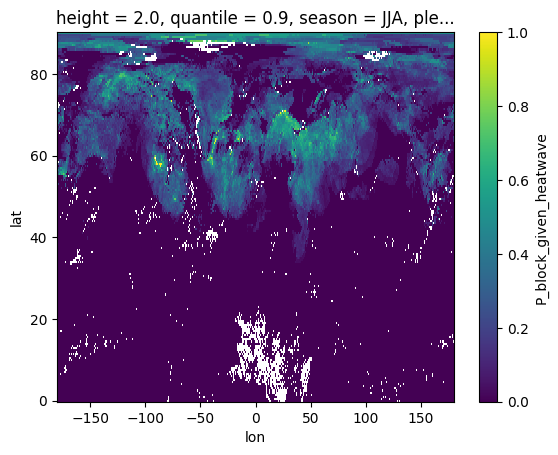

In [57]:
#Per grid cell, fraction of heatwave days that are blocked.
P_icon2km_JJA, Nheat_icon2km_JJA, Nco_icon2km_JJA = p_block_given_heatwave(
    block_icon2km, heat_icon2km, months=[6,7,8], min_hw_days=5
)
P_icon2km_JJA.plot()

In [60]:
##stratified by band
def to_daily_mask(da, is_bool=True):
    da2 = da.assign_coords(time=da.time.dt.floor("D"))
    da2 = da2.groupby("time").max()
    if is_bool:
        da2 = da2.astype(bool)
    return da2

def subset_months(da, months):
    m = da["time"].dt.month
    return da.where(m.isin(months), drop=True)

def p_block_given_heatwave_by_band(block_flag, heat_flag, months, bands,
                                  region_mask=None, min_hw_days=50):
    """
    Area-weighted P(block | heatwave) for each latitude band:
      sum(H*B*w) / sum(H*w)
    """
    # daily masks
    H = to_daily_mask(heat_flag, is_bool=True)
    B = to_daily_mask(block_flag, is_bool=False)

    # subset months (correct way)
    H = subset_months(H, months)
    B = subset_months(B, months)

    # align time/lat/lon on intersection
    H, B = xr.align(H, B, join="inner")

    if H.sizes["time"] == 0:
        raise ValueError("No overlapping daily timestamps after alignment.")

    # convert to int for counting
    H_i = H.astype("int8")
    B_i = (B > 0).astype("int8")

    # 2D area weights
    w_lat = np.cos(np.deg2rad(H_i["lat"]))
    w2d = w_lat.broadcast_like(H_i.isel(time=0))

    # optional region mask (lat, lon)
    if region_mask is not None:
        region_mask = region_mask.broadcast_like(w2d)
        w2d = w2d.where(region_mask)

    out = {}
    out_den = {}

    for name, (latmin, latmax) in bands.items():
        band = (H_i["lat"] >= latmin) & (H_i["lat"] < latmax)

        Hk = H_i.where(band)
        Bk = B_i.where(band)

        num = (Hk * Bk * w2d).sum(("time", "lat", "lon"), skipna=True)
        den = (Hk * w2d).sum(("time", "lat", "lon"), skipna=True)

        p = xr.where(den > 0, num / den, np.nan)

        if min_hw_days is not None:
            p = xr.where(den >= min_hw_days, p, np.nan)

        out[name] = float(p.values)
        out_den[name] = float(den.values)

    return out, out_den

In [61]:
bands_NH = {
    "tropics (0–15N)": (0, 15),
    "subtropics (15–30N)": (15, 30),
    "midlatitudes (30–60N)": (30, 60),
    "high latitudes (60–90N)": (60, 90),
}

p_band_icon2km, den_band_icon2km = p_block_given_heatwave_by_band(
    block_icon2km, heat_icon2km, months=[6,7,8], bands=bands_NH, region_mask=None, min_hw_days=50
)

print("P(block|heatwave) by band:", p_band_icon2km)
print("Effective HW-day weight by band:", den_band_icon2km)

P(block|heatwave) by band: {'tropics (0–15N)': 0.0, 'subtropics (15–30N)': 0.0, 'midlatitudes (30–60N)': 0.04565301910042763, 'high latitudes (60–90N)': 0.19547723233699799}
Effective HW-day weight by band: {'tropics (0–15N)': 365765.375, 'subtropics (15–30N)': 379012.03125, 'midlatitudes (30–60N)': 528743.5, 'high latitudes (60–90N)': 205732.21875}


# Blocking ICON 10 km

In [4]:
###

# Blocking ERA5

In [73]:
# ICON (already regridded to 0.5° from filename)
inpath = '/capstor/scratch/cscs/edolores/OBS/ERA5/Z500_era5/'
fvar   = 'z500'
dvar   = 'z'
temp = xr.open_mfdataset(
    f"{inpath}/{fvar}_day_*_0p5deg.nc",
    chunks={"time": 365, "lon": -1, "lat": -1},
    preprocess=preprocess
)[dvar].squeeze()

##NH
temp#=temp.sel(lat=slice(0,90))

<xarray.DataArray 'z' (time: 1827, lat: 181, lon: 720)> Size: 952MB
dask.array<getitem, shape=(1827, 181, 720), dtype=float32, chunksize=(1, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 15kB 2020-01-01T10:30:00 ... 2024-12-31T10...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    level    float64 8B 500.0
Attributes: (12/32)
    standard_name:                            geopotential
    long_name:                                Geopotential
    units:                                    m**2 s**-2
    cell_methods:                             valid_time: mean
    GRIB_paramId:                             129
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_longitudeOfLastGridPointInDegrees:   359.75
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                Geopotential
    GRIB_shortName:                           z
    GRIB_totalNumber:                         0
    GRIB_units:                               m**2 s**-2

In [74]:
# -----------------------
# Ensure same season selection (Apr–Oct) "we will use icon climatology"
# -----------------------
months_sel = [4,5,6,7,8,9,10]
temp  = temp.sel(time=temp["time.month"].isin(months_sel))
#etemp = etemp.sel(time=etemp["time.month"].isin(months_sel))

# (Optional) also slice ICON period if you like
# temp = temp.sel(time=slice("2017-01-01", "2023-12-31"))

# -----------------------
# Prepare time helpers
# -----------------------
t_icon   = temp.time
doy_icon = t_icon.dt.dayofyear

#t_era    = etemp.time
#doy_era  = t_era.dt.dayofyear

# Preallocate output with same shape as ICON
icon_std = xr.zeros_like(temp)

print('Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)')

# helper for circular day-of-year difference (handles wrap around)
def circ_doy_diff(a, b):
    # a, b are numpy arrays or scalars of day-of-year (1..366)
    d = np.abs(a - b)
    return np.minimum(d, 365 - d)

# -----------------------
# Main loop over ICON times; stats taken from ERA5
# -----------------------
for tt in range(t_icon.size):
    # 30-day window (±15 days) in DOY space on ERA5
    w_doy = circ_doy_diff(doy_icon.values, doy_icon.values[tt]) <= 15

    # 8-year window centered on ICON time[tt] (±1475 days) on ERA5
    w_time = np.abs((t_icon.values - t_icon.values[tt]).astype('timedelta64[D]')) <= np.timedelta64(1475, 'D')

    # Combined mask over ERA5 time
    vec = w_doy & w_time

    # Compute ERA5 climatology and std over that window
    # These broadcast over lat/lon (same 0.5° grid as ICON)
    # (If any std==0, avoid division by zero)
    clim = temp.isel(time=vec).mean('time')
    std  = temp.isel(time=vec).std('time')
    
#    icon_std[tt, :, :] = xr.where(std > 0, (temp.isel(time=tt) - clim) / std, np.nan)
    icon_std[tt, :, :] = (temp.isel(time=tt) - clim)

print('select months')
icon_std = icon_std.sel(time=icon_std.time.dt.month.isin([5,6,7,8,9])).compute()
icon_std

Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)
select months


<xarray.DataArray 'z' (time: 765, lat: 181, lon: 720)> Size: 399MB
array([[[   53.59375 ,    50.222656,    47.953125, ...,    52.878906,
            54.027344,    53.558594],
        [   55.25    ,    54.55078 ,    50.109375, ...,    49.160156,
            52.98047 ,    52.88672 ],
        [   56.464844,    57.164062,    57.535156, ...,    49.44922 ,
            57.14453 ,    56.976562],
        ...,
        [-1783.0234  , -1782.8633  , -1782.6641  , ..., -1783.6016  ,
         -1783.4062  , -1783.2109  ],
        [-1800.3477  , -1800.2578  , -1800.1523  , ..., -1800.6055  ,
         -1800.5703  , -1800.4688  ],
        [-1821.6172  , -1821.6172  , -1821.6172  , ..., -1821.6172  ,
         -1821.6172  , -1821.6172  ]],

       [[  101.69531 ,   103.9375  ,   106.26953 , ...,    97.1875  ,
            99.05078 ,   100.14844 ],
        [  100.37891 ,   102.15234 ,   104.21875 , ...,    95.5     ,
            97.47656 ,    98.67969 ],
        [   99.12109 ,   100.19141 ,   101.14844 , ...,    95.74219 ,
            97.26953 ,    98.23047 ],
...
          1156.8125  ,  1157.6523  ],
        [ 1116.5273  ,  1116.9531  ,  1117.3359  , ...,  1115.2617  ,
          1115.6875  ,  1116.0742  ],
        [ 1054.2812  ,  1054.2812  ,  1054.2812  , ...,  1054.2812  ,
          1054.2812  ,  1054.2812  ]],

       [[   24.15625 ,    20.652344,    16.230469, ...,    37.785156,
            32.92578 ,    28.195312],
        [   26.300781,    23.050781,    18.722656, ...,    36.171875,
            32.67578 ,    29.375   ],
        [   27.621094,    24.839844,    21.019531, ...,    35.273438,
            32.785156,    30.441406],
        ...,
        [  765.3828  ,   766.1914  ,   767.09766 , ...,   762.8281  ,
           763.6758  ,   764.53906 ],
        [  768.2578  ,   768.66406 ,   769.08203 , ...,   766.91016 ,
           767.3672  ,   767.8281  ],
        [  766.0156  ,   766.0156  ,   766.0156  , ...,   766.0156  ,
           766.0156  ,   766.0156  ]]],
      shape=(765, 181, 720), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-05-01T10:30:00 ... 2024-09-30T10:...
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    level    float64 8B 500.0
Attributes: (12/32)
    standard_name:                            geopotential
    long_name:                                Geopotential
    units:                                    m**2 s**-2
    cell_methods:                             valid_time: mean
    GRIB_paramId:                             129
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_longitudeOfLastGridPointInDegrees:   359.75
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                Geopotential
    GRIB_shortName:                           z
    GRIB_totalNumber:                         0
    GRIB_units:                               m**2 s**-2

In [75]:
### Save / open files
#print('write anomalies to netcdf')
icon_std.to_netcdf(inpath+'/ERA5_'+fvar+'_NH_19592023_AMJJASO_daily_MA_simclim.nc')
#print('open anomalies in netcdf')
#icon_std = xr.open_dataset(inpath+'/ERA5_'+fvar+'_NH_19592023_AMJJASO_daily_MA_simclim.nc')['t_2m']

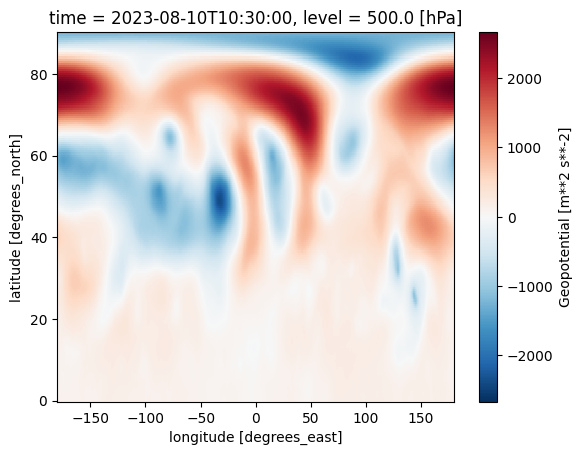

In [76]:
### temporal smooth
smooth=2 ### 8 for 6-hourly, 2 for daily
icon_std_smooth = icon_std.rolling(time=smooth, center=True).mean()
icon_std_smooth

##### Smoothing spatially
#smooth_passes=5
#icon_std_smooth = calculate_smoothed_field(
#        icon_std, smooth_passes, time_name='time', lat_name='lat', lon_name='lon')

# Rename the DataArray
icon_std_smooth= icon_std_smooth.rename(dvar)
#snap=icon_std.sel(time='2023-08-10',drop=True)
snap=icon_std_smooth.sel(time='2023-08-10',drop=True)
snap.plot()

In [77]:
### Outputs
outpath='/capstor/scratch/cscs/edolores/OBS/ERA5/Blocking/'

### intitate
anom = contrack()
anom.read_xarray(icon_std_smooth.to_dataset())

def _get_resolution_patched(self, dim, force=False):
    # Try to get a pandas Index (DatetimeIndex, Float64Index, etc.)
    idx = self.ds[dim].to_index()

    # Case 1: time-like coordinate → return timedelta64[h]
    if isinstance(idx, (pd.DatetimeIndex, pd.TimedeltaIndex)):
        diffs = idx[1:] - idx[:-1]  # TimedeltaIndex
        delta = np.unique(diffs.to_numpy(dtype='timedelta64[h]'))
        return delta[0]

    # Case 2: numeric coordinate (e.g., degrees) → return float
    # (Work directly with numpy array to be robust to Index subclasses)
    arr = np.asarray(idx, dtype=float)
    diffs = np.diff(arr)
    # protect against tiny numerical noise
    delta = np.unique(np.round(diffs, 10))
    return float(delta[0])


# apply the patch
contrack._get_resolution = _get_resolution_patched

anom.set_up(force=True)
anom.ds=anom.ds.compute()

# Finally, track blocking anticyclones (>=150gmp, 50% overlap twosided, 5 timesteps persistence (here 5 days))
anom.run_contrack(variable=dvar,
                   threshold = anom[dvar].sel(lat=slice(50, 80)).quantile([0.90], dim='time').mean().values, # 177gmp
                   gorl='>=',
                   overlap=0.5, #0.5, 0.7
                   persistence=5, #5, 20
                   twosided=True)


### save blobs 
anom.to_netcdf(outpath+'BLOCKS_ERA5_NH_20202024_AMJJASO_daily_MA_simclim.nc')

### lifecycle
anom_df = anom.run_lifecycle(flag='flag', variable=dvar)
anom_df.to_csv(outpath+'BLOCKS_ERA5_NH_19592023_AMJJASO_daily_MA_simclim.csv', index=False)

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:129: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims[self._get_name_time()]
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: 
Run ConTrack 
########### 
    threshold:    >= 1200.728172912039 
    overlap:      0.5 
    persistence:  5 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Apply overlap...
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:704: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, ple

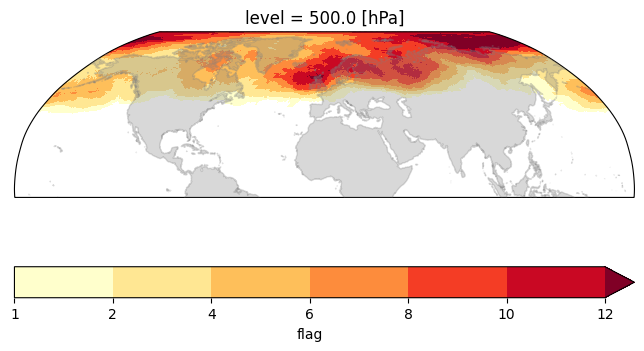

In [78]:
###Frequency
mean_hw = xr.where(anom['flag']>1,1,0).mean(dim='time')*100
#mean_hw.plot(cmap='YlOrRd', levels=np.arange(0, 5, 0.5))

proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw.plot(ax=ax1, cmap='YlOrRd', levels=[1,2,4,6,8,10,12],transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)

# Plotting resuls

In [79]:
def to_daily_mask(da, is_bool=True):
    """
    Convert time to daily (floor) and aggregate duplicates.
    For event masks, daily max is appropriate.
    """
    da2 = da.assign_coords(time=da.time.dt.floor("D"))
    da2 = da2.groupby("time").max()
    if is_bool:
        da2 = da2.astype(bool)
    return da2

def p_block_given_heatwave(block_flag, heat_flag, months, min_hw_days=5):
    """
    Compute P(block | heatwave) per grid cell:
      sum_t (H & B) / sum_t (H)
    """
    # daily masks
    H = to_daily_mask(heat_flag, is_bool=True)
    B = to_daily_mask(block_flag, is_bool=False)  # 0/1 integer ok

    # subset months
    H = H.sel(time=H.time.dt.month.isin(months))
    B = B.sel(time=B.time.dt.month.isin(months))

    # align on daily time + common grid
    H, B = xr.align(H, B, join="inner")

    # convert to int for counting
    H_i = H.astype("int8")
    B_i = (B > 0).astype("int8")

    num = (H_i * B_i).sum("time")  # co-occurrence count
    den = H_i.sum("time")          # heatwave-day count

    P = xr.where(den > 0, num / den, np.nan)
    if min_hw_days is not None:
        P = P.where(den >= min_hw_days)

    P.name = "P_block_given_heatwave"
    return P, den, num

def event_lengths_from_hwmask(hw_mask: xr.DataArray, min_duration: int = 3) -> xr.DataArray:
    # force boolean mask
    x = hw_mask.fillna(False).astype(bool)

    start = x & (~x.shift(time=1,  fill_value=False))
    end   = x & (~x.shift(time=-1, fill_value=False))

    idx = xr.DataArray(
        np.arange(x.sizes["time"], dtype=np.int64),
        coords={"time": x.time},
        dims="time",
    )

    start_idx = idx.where(start)
    start_idx_ffill = start_idx.ffill("time")

    # IMPORTANT: use NaN outside events
    run_len = xr.where(x, (idx - start_idx_ffill + 1), np.nan)

    # keep only end days of events
    event_len = run_len.where(end)
    event_len = event_len.where(event_len >= min_duration)

    return event_len.astype("float32").rename("event_length_days")


In [80]:
### ERA5
#Block
block_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Blocking/BLOCKS_ERA5_NH_20202024_AMJJASO_daily_MA_simclim.nc')['flag']
block_era5 = xr.where(block_era5>1,1,0)
block_era5_feq = block_era5.mean(dim='time')*100
### heatwaves
heat_era5=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/hw_mask_2020-2024_jja.nc')['heatwave_day_by_season']


### ICON 2.5 km
#Block
block_icon2km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Blocking/BLOCKS_ICON_NH_20202024_AMJJASO_daily_MA_simclim.nc')['flag']
block_icon2km = xr.where(block_icon2km>1,1,0)
block_icon2km_feq = block_icon2km.mean(dim='time')*100
### heatwaves
heat_icon2km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']

### ICON 10 km
#jja_icon10km=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/Heatwaves/Russo/hw_mask_simclim_jja.nc')['heatwave_day_by_season']
#print(jja_icon10km)
#block_icon2km_feq.plot()

In [82]:
#block_era5 

In [83]:
#Per grid cell, fraction of heatwave days that are blocked
### ERA5
P_era5_JJA, Nheat_era5_JJA, Nco_era5_JJA = p_block_given_heatwave(
    block_era5, heat_era5, months=[6,7,8], min_hw_days=5
)
###ICON 2.5 km
P_icon2km_JJA, Nheat_icon2km_JJA, Nco_icon2km_JJA = p_block_given_heatwave(
    block_icon2km, heat_icon2km, months=[6,7,8], min_hw_days=5
)

### In percentage
P_era5_JJA *=100
P_icon2km_JJA *= 100

###bias
P_bias=(P_icon2km_JJA - P_era5_JJA)

#P_icon2km_JJA.plot()
data_list = [P_era5_JJA, P_icon2km_JJA]

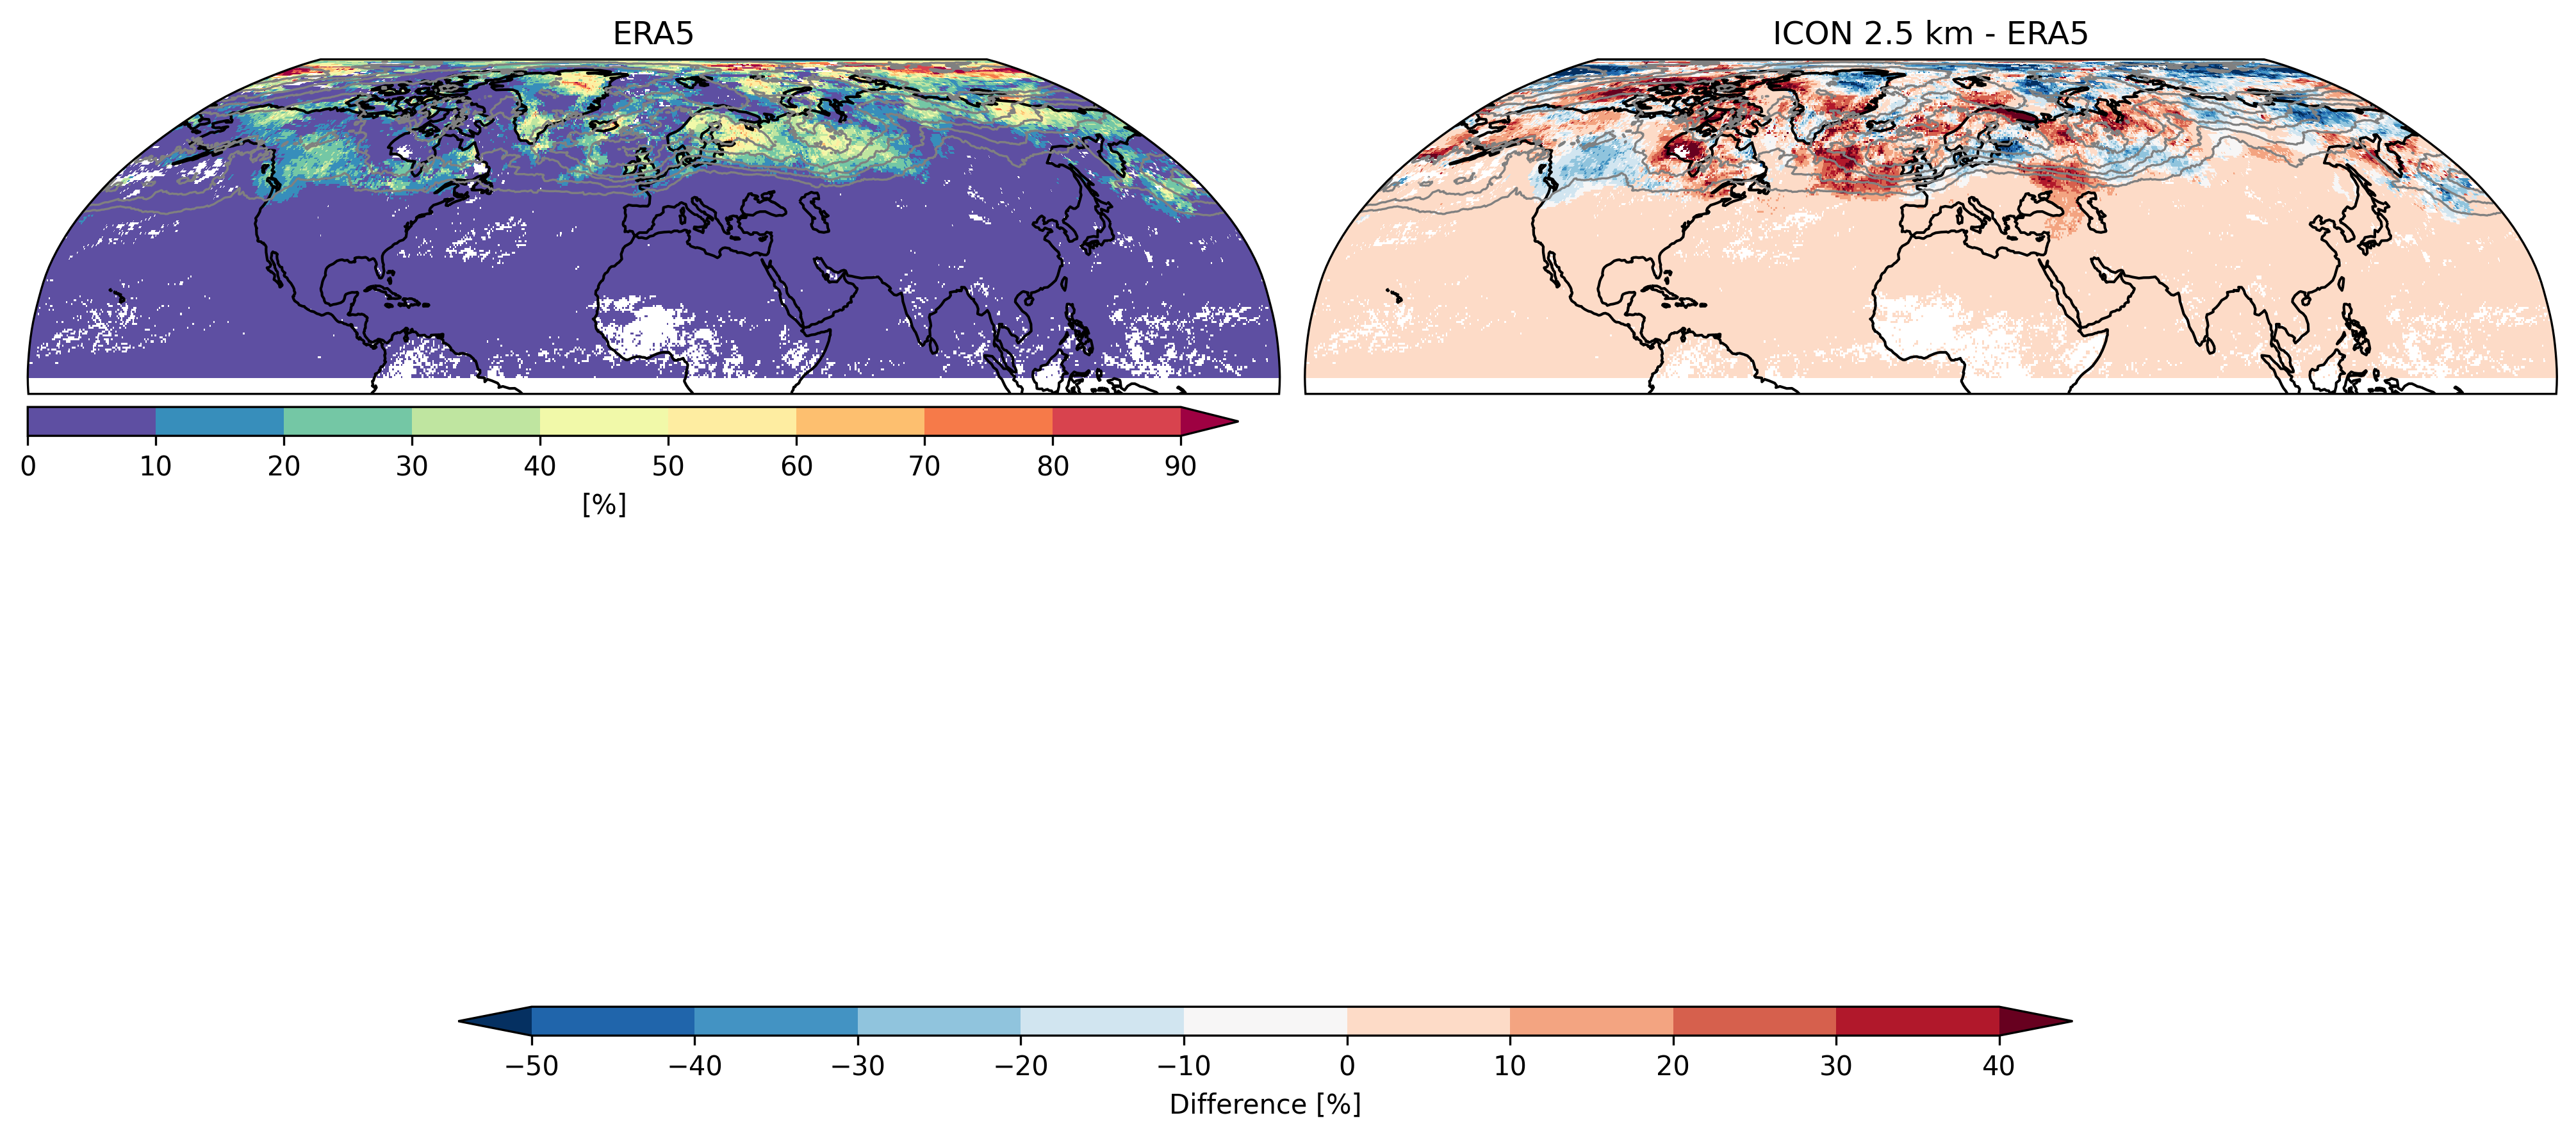

In [86]:
### Plot ERA5 and ICON 2.5 km
proj = ccrs.Robinson(central_longitude=0)

fig, axes = plt.subplots(
    2, 2, figsize=(14, 6), dpi=300,
    subplot_kw={'projection': proj}
)

levels  = np.arange(0, 100, 10)      # absolute
alevels = np.arange(-50, 50, 10)     # anomalies

# --- Plot panels (NO colorbars here) ---
p_abs = P_era5_JJA.plot(
    ax=axes[0,0], cmap='Spectral_r', levels=levels,
    transform=ccrs.PlateCarree(), extend='max',
    add_colorbar=False
)
p_bk = block_era5_feq.plot.contour(ax=axes[0,0], colors='grey', linewidths=0.8, levels=[2,4,6,8,10,12], transform=ccrs.PlateCarree())

axes[0,0].coastlines()
axes[0,0].set_title('ERA5')

p_an1 = P_bias.plot(
    ax=axes[0,1], cmap='RdBu_r', levels=alevels,
    transform=ccrs.PlateCarree(), extend='both',
    add_colorbar=False
)
p_bk = block_era5_feq.plot.contour(ax=axes[0,1], colors='grey', linewidths=0.8, levels=[2,4,6,8,10,12], transform=ccrs.PlateCarree())

axes[0,1].coastlines()
axes[0,1].set_title('ICON 2.5 km - ERA5')

#p_an2 = mean_hw_days_land_res.plot(
#    ax=axes[1,0], cmap='RdBu', levels=alevels,
#    transform=ccrs.PlateCarree(), extend='both',
#    add_colorbar=False
#)
#axes[1,0].coastlines()
#axes[1,0].set_title('ICON 2.5 km - ICON 10 km')

# Example: your 4th panel anomaly
#p_an3 = mean_hw_days_land_res.plot(
#    ax=axes[1,1], cmap='RdBu', levels=alevels,
#    transform=ccrs.PlateCarree(), extend='both',
#    add_colorbar=False
#)
#axes[1,1].coastlines()
#axes[1,1].set_title('Another anomaly')

# ---- Layout: create space for colorbars ----
# Leave room at bottom for anomaly cbar and between rows for absolute cbar
fig.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.12,
                    wspace=0.02, hspace=0.20)

# ---- Two horizontal colorbars with explicit positions ----
# [left, bottom, width, height] in figure coordinates (0..1)

# Absolute colorbar: centered between rows (tune "bottom" as needed)
cax_abs = fig.add_axes([0.04, 0.58, 0.45, 0.025])
cbar_abs = fig.colorbar(p_abs, cax=cax_abs, orientation='horizontal')
cbar_abs.set_label('[%]')

# Anomaly colorbar: bottom of figure spanning most of the width
cax_anom = fig.add_axes([0.20, 0.06, 0.60, 0.025])
cbar_anom = fig.colorbar(p_an1, cax=cax_anom, orientation='horizontal')
cbar_anom.set_label('Difference [%]')

# Hide unused axes
for ax in axes.flatten()[len(data_list):]:
    ax.set_visible(False)

#plt.tight_layout()

sufix='JJA'
domain='NH'
plt.savefig(
    dir_figures + f'Block_heat_{sufix}_{domain}.jpg',
    dpi=300, facecolor='white', bbox_inches='tight', pad_inches=0
)

In [87]:
### End-day conditioning (event-based):
#“Is the heatwave event ending under blocking?”

In [88]:
def to_daily_mask(da: xr.DataArray, make_bool: bool = False) -> xr.DataArray:
    da2 = da.assign_coords(time=da.time.dt.floor("D"))
    da2 = da2.groupby("time").max()
    if make_bool:
        da2 = da2.fillna(False).astype(bool)
    return da2

def subset_months(da, months):
    return da.where(da.time.dt.month.isin(months), drop=True)

def band_event_mean_duration(event_len, block_mask, latmin, latmax, mode="blocked",
                             region_mask=None, min_events=200):
    band = (event_len.lat >= latmin) & (event_len.lat < latmax)
    D = event_len.where(band)
    B = block_mask.where(band)
    Bbool = (B > 0)

    if mode == "blocked":
        select = D.notnull() & Bbool
    elif mode == "unblocked":
        select = D.notnull() & (~Bbool)
    else:
        raise ValueError("mode must be 'blocked' or 'unblocked'")

    # area weights
    wlat = np.cos(np.deg2rad(D.lat))
    w2d = wlat.broadcast_like(D.isel(time=0))

    if region_mask is not None:
        w2d = w2d.where(region_mask.broadcast_like(w2d))

    num = (D.where(select) * w2d).sum(("time","lat","lon"), skipna=True)
    den = (w2d.where(select)).sum(("time","lat","lon"), skipna=True)

    meanD = xr.where(den > 0, num / den, np.nan)
    meanD = xr.where(den >= min_events, meanD, np.nan)

    return float(meanD.values), float(den.values)

def duration_summary_by_bands(hw_mask, block_mask, months, bands,
                              min_duration=3, region_mask=None, min_events=200):
    # daily + months
    H = subset_months(to_daily_mask(hw_mask, make_bool=True), months)
    B = subset_months(to_daily_mask(block_mask, make_bool=False), months)

    # align
    H, B = xr.align(H, B, join="inner")

    # event endpoints with lengths
    event_len = event_lengths_from_hwmask(H, min_duration=min_duration)

    out = {}
    for name, (a,b) in bands.items():
        mB, nB = band_event_mean_duration(event_len, B, a, b, mode="blocked",
                                          region_mask=region_mask, min_events=min_events)
        mU, nU = band_event_mean_duration(event_len, B, a, b, mode="unblocked",
                                          region_mask=region_mask, min_events=min_events)
        out[name] = {"blocked": mB, "unblocked": mU, "Nw_blocked": nB, "Nw_unblocked": nU}
    return out
def plot_duration_conditioned(summary_by_model, bands_order, model_order):
    """
    summary_by_model: dict like { "ERA5": summary_era5, "ICON-2.5": summary_icon2km, ... }
    each summary_*: dict band -> {"blocked":..., "unblocked":...}
    """
    x = np.arange(len(bands_order))
    width = 0.18

    fig, ax = plt.subplots(figsize=(10,4))

    for i, model in enumerate(model_order):
        summ = summary_by_model[model]
        blocked = [summ[b]["blocked"] for b in bands_order]
        unblocked = [summ[b]["unblocked"] for b in bands_order]

        # position: two bars per model (blocked/unblocked)
        ax.bar(x + (i - (len(model_order)-1)/2)*width*2, blocked, width, label=f"{model} blocked")
        ax.bar(x + (i - (len(model_order)-1)/2)*width*2 + width, unblocked, width, label=f"{model} unblocked", alpha=0.6)

    ax.set_xticks(x)
    ax.set_xticklabels(bands_order)
    ax.set_ylabel("Mean heatwave duration (days)")
    ax.set_title("Heatwave duration conditioned on blocking (event-based)")
    ax.legend(ncol=2, fontsize=8)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_duration_conditioned_delta(summary_by_model, bands_order, model_order):
    """
    Plots the BLOCKING EFFECT on heatwave duration:
        ΔD = mean_duration_blocked - mean_duration_unblocked

    summary_by_model: dict like 
      { "ERA5": summary_era5, "ICON-2.5": summary_icon2km, ... }

    bands_order: list of latitude bands in plotting order
    model_order: list of models in plotting order
    """

    x = np.arange(len(bands_order))
    width = 0.18

    fig, ax = plt.subplots(figsize=(10, 4.5))

    for i, model in enumerate(model_order):
        summ = summary_by_model[model]

        # Compute ΔD for each band
        delta = [
            (summ[b]["blocked"] - summ[b]["unblocked"])
            for b in bands_order
        ]

        ax.bar(
            x + (i - (len(model_order)-1)/2) * width,
            delta,
            width,
            label=model
        )

    ax.axhline(0, color="black", linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(bands_order)
    ax.set_ylabel("Blocking effect on heatwave duration (days)\n$\\Delta D = D_{blocked} - D_{unblocked}$")
    ax.set_title("Dependence of heatwave persistence on atmospheric blocking")
    ax.legend(loc="best", ncol=2, fontsize=9)
    ax.grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

In [92]:
bands_NH = {
    "tropics": (0, 15),
    "subtropics": (15, 30),
    "midlat": (30, 60),
    "highlat": (60, 90),
}

summary_era5 = duration_summary_by_bands(
    heat_era5, block_era5,
    months=[6,7,8],
    bands=bands_NH,
    min_duration=3,
    min_events=200
)

summary_icon2km = duration_summary_by_bands(
    heat_icon2km, block_icon2km,
    months=[6,7,8],
    bands=bands_NH,
    min_duration=3,
    min_events=200
)
summary_era5

{'tropics': {'blocked': nan,
  'unblocked': 3.9711248874664307,
  'Nw_blocked': 0.0,
  'Nw_unblocked': 70141.2578125},
 'subtropics': {'blocked': nan,
  'unblocked': 4.138829231262207,
  'Nw_blocked': 0.0,
  'Nw_unblocked': 82419.9375},
 'midlat': {'blocked': 3.4501564502716064,
  'unblocked': 4.17001485824585,
  'Nw_blocked': 1165.1990966796875,
  'Nw_unblocked': 119822.6640625},
 'highlat': {'blocked': 4.001893520355225,
  'unblocked': 3.866459369659424,
  'Nw_blocked': 5186.91455078125,
  'Nw_unblocked': 43058.2578125}}

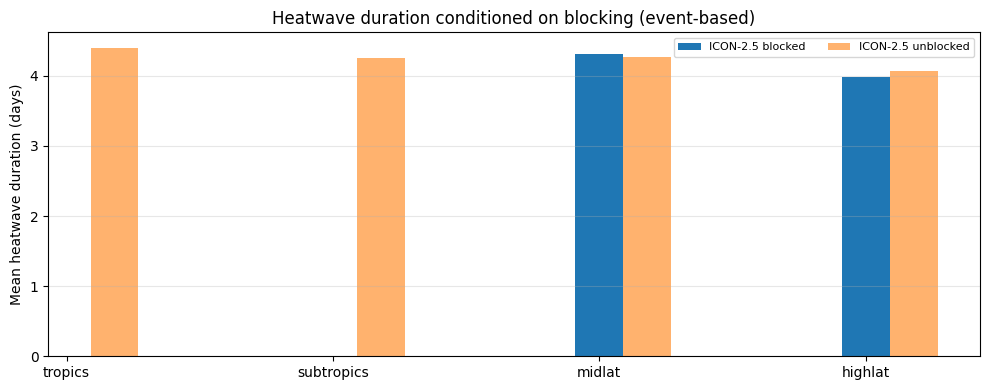

In [93]:
#quick_bar_plot(summary_icon2km, ["tropics","subtropics","midlat","highlat"])
bands_order = ["tropics", "subtropics", "midlat", "highlat"]
model_order = ["ICON-2.5"]
plot_duration_conditioned(
    {"ICON-2.5": summary_icon2km},
    bands_order=bands_order,
    model_order=model_order
)

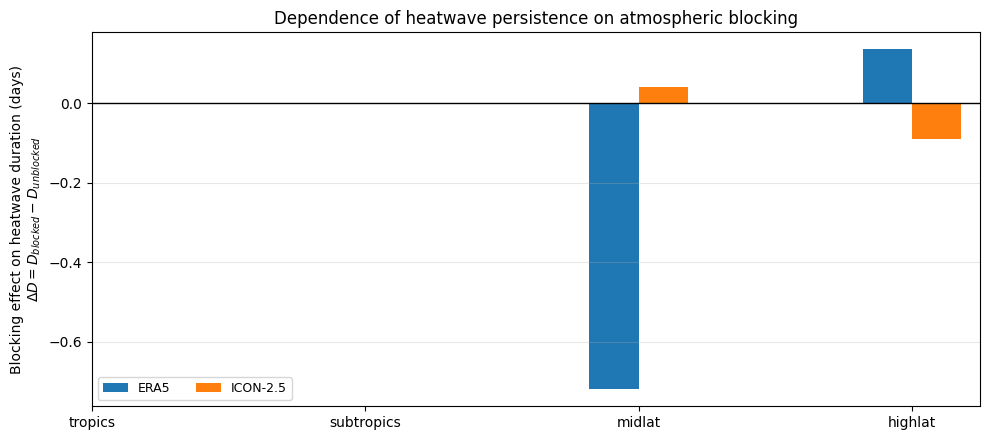

In [94]:
plot_duration_conditioned_delta(
    {
        "ERA5": summary_era5,
        "ICON-2.5": summary_icon2km,
#        "ICON-10": summary_icon10km,
#        "ICON-10-ON": summary_icon10km_on,
    },
    bands_order=["tropics","subtropics","midlat","highlat"],
    model_order=["ERA5", "ICON-2.5"]
    #model_order=["ERA5"],"ICON-2.5","ICON-10","ICON-10-ON"]
)
